- LTV ratio histogram

# **<center> Credit risk model - HMEQ data </center>**

<center><span style="font-size:24px;"><b>Section 3:</b> Calculation of Risk-Weighted Assets</span></center>

## Introduction to this section

In this section I calculate the capital requirements for the lender based on the standardized approach (SA) and the foundation internal ratings-based approach (F-IRB). These approaches are outlined in the Basel III banking regulations and described in more depth in the relevant section.

## Imports

In [997]:
from IPython.core.display import HTML
import pandas as pd
import numpy as np
import sys
import os
from scipy import stats
import plotly.graph_objects as go
import re

sys.path.append(os.path.abspath(".."))
import random
from functions import assign_risk_weight

with open("../styles/styles.css", "r") as file:
    css = file.read()
display(HTML(f"<style>{css}</style>"))

pd.options.display.float_format = "{:,.2f}".format

## Data cleaning

I first prepare my original data to allow me to calculate RWA using the standardised approach. I import the original data frame, so that I can access the values for `OUTSTANDING MORTGAGE`, which represents the exposure at default (EAD). I transform anomalies, where appropriate. This is enough to calculate RWA using the standardised approach.

In [998]:
original_df = pd.read_csv("../datasets/df_original.csv")
original_df.set_index("idx", inplace=True)

# original_df.head(6)

### Anomaly transformation

Many of the borrowers with unreasonably high LTV ratios also have mortgages above the 99th percentile. It is therefore reasonable to assume that these mortgages have been incorrectly entered.

In [999]:
# original_df[original_df["LTV RATIO"] > 1.15]

In [1000]:
np.nanpercentile(original_df["OUTSTANDING MORTGAGE"], 99)

232230.41000000003

I winsorize all mortgages above $200,000 that are associated with an LTV ratio higher than 1.15. This gives us a conservative estimate of EAD for each row without the numbers being ridiculous.

In [1001]:
filter = (original_df["LTV RATIO"] > 1.15) & (
    original_df["OUTSTANDING MORTGAGE"] > 200000
)

# set LTV ratios associated with the filter to NaN
original_df.loc[filter, "LTV RATIO"] = np.nan

# set Outstanding Mortgage values associated with the filter to 1.15 * Property Value
original_df.loc[filter, "OUTSTANDING MORTGAGE"] = (
    1.15 * original_df.loc[filter, "PROPERTY VALUE"]
)

For all other values where LTV ratio is above 1.15, I want these ratios to be set to NaN (so that they don't interfere with my calculation of the mean LTV ratio).

In [1002]:
# to calculate the mean LTV ratio and use this to impute missing mortgage/property values
mask = original_df["LTV RATIO"] > 1.15
original_df.loc[mask, "LTV RATIO"] = np.nan

I then calculate the mean LTV ratio, which I will use to help impute missing mortgage and missing property values. I choose the arithmetic mean.

In [1003]:
# arithmetic mean
mean_LTV = original_df["LTV RATIO"].mean()

# weighted mean
# mean_LTV = (original_df["OUTSTANDING MORTGAGE"] / original_df["PROPERTY VALUE"]).mean()


mean_LTV

0.6837511239783576

In [1004]:
# original_df["LTV RATIO"].median()

I create new columns to flag where property values or outstanding mortgage values are missing.

In [1005]:
original_df.shape

(5960, 12)

In [1006]:
original_df["missing_property_value"] = original_df["PROPERTY VALUE"].isna().astype(int)
original_df["missing_mortgage"] = original_df["OUTSTANDING MORTGAGE"].isna().astype(int)

In [1007]:
original_df[original_df["missing_mortgage"] == 1]

,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,JOB,YEARS AT JOB,DEROGATORY REPORTS,DELINQUENT CREDIT LINES,OLDEST CREDIT (MONTHS),RECENT CREDIT ENQUIRIES,CREDIT LINES,DEBTINC,LTV RATIO,missing_property_value,missing_mortgage
idx,,,,,,,,,,,,,,
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
9,1,NaN,"62,250.00",Sales,16.00,0.00,0.00,115.80,0.00,13.00,NaN,NaN,0,1
24,1,NaN,"17,180.00",Other,NaN,0.00,0.00,14.57,3.00,4.00,NaN,NaN,0,1
40,1,NaN,"8,800.00",Other,2.00,0.00,1.00,77.77,0.00,3.00,NaN,NaN,0,1
41,1,NaN,"33,000.00",Other,1.00,0.00,1.00,23.30,1.00,2.00,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,NaN,"84,205.00",Other,NaN,0.00,0.00,339.67,0.00,7.00,22.64,NaN,0,1
5883,0,NaN,"81,322.00",Self,9.00,0.00,0.00,171.45,0.00,22.00,24.71,NaN,0,1
5884,0,NaN,"91,309.00",Other,NaN,0.00,0.00,349.80,0.00,6.00,22.06,NaN,0,1


I delete rows where both values are missing, because these have no impact on the bank's assets.

In [1008]:
original_df = original_df[
    ~(
        (original_df["missing_property_value"] == 1)
        & (original_df["missing_mortgage"] == 1)
    )
]

I then replace 'OUTSTANDING MORTGAGE' values where mortgages are missing, and 'PROPERTY VALUE' values where these are missing.

In [1009]:
original_df.loc[original_df["missing_mortgage"] == 1, "OUTSTANDING MORTGAGE"] = (
    mean_LTV * original_df["PROPERTY VALUE"]
)

# original_df[original_df["missing_mortgage"] == 1]

In [1010]:
original_df.loc[original_df["missing_property_value"] == 1, "PROPERTY VALUE"] = (
    original_df["OUTSTANDING MORTGAGE"] / mean_LTV
)

original_df[original_df["missing_property_value"] == 1]

,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,JOB,YEARS AT JOB,DEROGATORY REPORTS,DELINQUENT CREDIT LINES,OLDEST CREDIT (MONTHS),RECENT CREDIT ENQUIRIES,CREDIT LINES,DEBTINC,LTV RATIO,missing_property_value,missing_mortgage
idx,,,,,,,,,,,,,,
10,1,"22,608.00","33,064.66",NaN,18.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
17,1,"23,030.00","33,681.85",NaN,19.00,NaN,NaN,NaN,NaN,NaN,3.71,NaN,1,0
23,1,"18,000.00","26,325.37",Mgr,22.00,NaN,2.00,121.73,0.00,10.00,NaN,NaN,1,0
57,1,"23,159.00","33,870.51",Mgr,20.00,NaN,2.00,117.81,0.00,9.00,0.52,NaN,1,0
119,1,"57,000.00","83,363.67",Other,5.00,NaN,NaN,222.60,1.00,13.00,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,1,"26,976.00","39,452.95",Mgr,8.30,1.00,0.00,111.60,1.00,6.00,NaN,NaN,1,0
5818,1,"106,000.00","155,027.17",Mgr,0.80,0.00,2.00,252.63,3.00,32.00,NaN,NaN,1,0
5822,1,"30,338.00","44,369.95",Mgr,8.00,0.00,0.00,91.43,0.00,5.00,35.08,NaN,1,0


I recalculate LTV ratios to adapt to the changes I have made.

In [1011]:
original_df["LTV RATIO"] = (
    original_df["OUTSTANDING MORTGAGE"] / original_df["PROPERTY VALUE"]
)

# check that the transformation worked
# original_df[original_df["missing_property_value"] == 1]

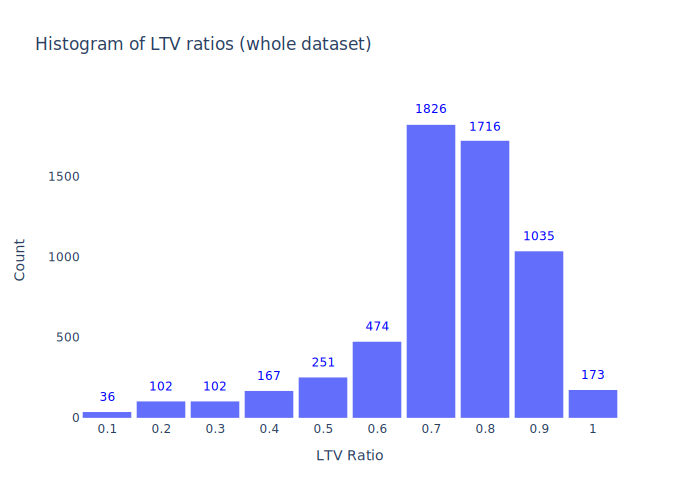

In [1012]:
bins = np.arange(0, 1.1, 0.10)

bin_centers = (bins[:-1] + bins[1:]) / 2

counts, _ = np.histogram(original_df["LTV RATIO"], bins=bins)

fig = go.Figure(
    data=[
        go.Histogram(
            x=original_df["LTV RATIO"],
            xbins=dict(
                start=bins[0],
                end=bins[-1],
                size=0.10,
            ),
            showlegend=False,
        ),
        go.Scatter(
            x=bin_centers,
            y=counts + 50,
            mode="text",
            text=counts,
            textposition="top center",
            textfont=dict(color="blue"),
            showlegend=False,
        ),
    ]
)

fig.update_layout(
    title_text="Histogram of LTV ratios (whole dataset)",
    xaxis_title_text="LTV Ratio",
    yaxis_title_text="Count",
    bargap=0.1,
    plot_bgcolor="white",
    xaxis=dict(
        tickmode="array",
        tickvals=bin_centers,
        ticktext=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    ),
)

fig.show("svg")

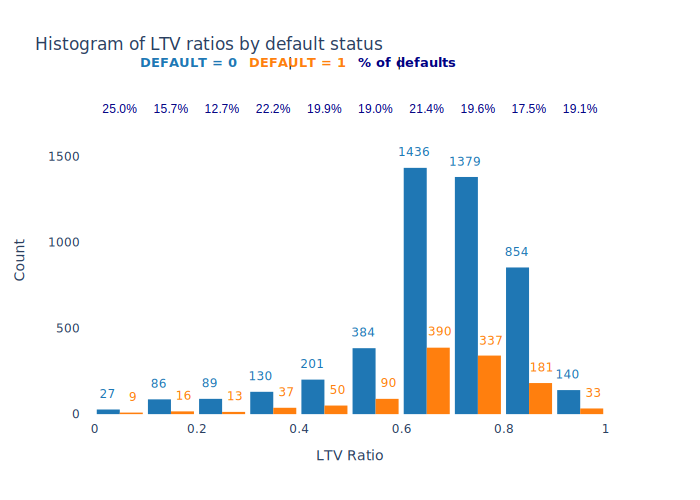

In [1013]:
colour_map = {0: "rgb(31, 119, 180)", 1: "rgb(255, 127, 14)"}

ltv_default_0 = original_df[original_df["DEFAULT"] == 0]["LTV RATIO"]
ltv_default_1 = original_df[original_df["DEFAULT"] == 1]["LTV RATIO"]

bins = np.arange(0, 1.1, 0.1)

counts_0, bin_edges = np.histogram(ltv_default_0, bins=bins)
counts_1, _ = np.histogram(ltv_default_1, bins=bins)

total_counts = counts_0 + counts_1
default_percentages = np.where(total_counts > 0, (counts_1 / total_counts) * 100, 0)
default_percentage_labels = [
    f"{p:.1f}%" if total_counts[i] > 0 else ""
    for i, p in enumerate(default_percentages)
]

bin_width = 0.1
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

shift = bin_width / 4
x_positions_0 = bin_centers - shift
x_positions_1 = bin_centers + shift

max_bar_height = max(max(counts_0), max(counts_1))

fixed_annotation_height = max_bar_height + 300
y_positions_fixed = [fixed_annotation_height] * len(bin_centers)

fig = go.Figure()

# Blue bars for DEFAULT = 0
fig.add_trace(
    go.Histogram(
        x=ltv_default_0,
        xbins=dict(start=0, end=1, size=0.10),
        marker=dict(color=colour_map[0]),
        name="DEFAULT = 0",
        opacity=1.0,
        histfunc="count",
    )
)

# Orange bars for DEFAULT = 1
fig.add_trace(
    go.Histogram(
        x=ltv_default_1,
        xbins=dict(start=0, end=1, size=0.10),
        marker=dict(color=colour_map[1]),
        name="DEFAULT = 1",
        opacity=1.0,
        histfunc="count",
    )
)

fig.add_trace(
    go.Scatter(
        x=x_positions_0,
        y=counts_0 + 50,  # Slight offset for visibility
        mode="text",
        text=counts_0,
        textposition="top center",
        textfont=dict(color=colour_map[0]),
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=x_positions_1,
        y=counts_1 + 50,
        mode="text",
        text=counts_1,
        textposition="top center",
        textfont=dict(color=colour_map[1]),
        showlegend=False,
    )
)

# Fixed-position percentage labels above the tallest bar
fig.add_trace(
    go.Scatter(
        x=bin_centers,
        y=y_positions_fixed,
        mode="text",
        text=default_percentage_labels,
        textposition="top center",
        textfont=dict(color="navy", size=12, family="Arial"),
        showlegend=False,
    )
)

# subtitle
fig.add_annotation(
    x=-0.098,
    y=1.15,
    xref="paper",
    yref="paper",
    text=(
        "<span style='color:rgb(31, 119, 180);'><b>DEFAULT = 0</b></span> "
        "<span style='color:black;'>|</span> "
        "<span style='color:rgb(255, 127, 14);'><b>DEFAULT = 1</b></span> "
        "<span style='color:black;'>|</span> "
        "<span style='color:navy;'><b>% of defaults</b></span>"
    ),
    showarrow=False,
    font=dict(size=13),
    align="center",
)

fig.update_layout(
    title_text="Histogram of LTV ratios by default status",
    xaxis_title_text="LTV Ratio",
    yaxis_title_text="Count",
    bargap=0.1,
    plot_bgcolor="white",
    barmode="group",
    showlegend=False,
)

fig.show("svg")

## Standardised approach

I am now able to apply the standardised approach (SA) to my data. The standardised approach to credit risk is one approach used to calculate a bank's capital requirements in accordance with Basel III banking regulations (BIS, 2024). The approach uses standardised risk weights to calculate risk-weighted assets (RWA), which is calculated using the following formula:

$$
\text{RWA} = \sum (\text{risk weight} \times \text{exposure amount})
$$

An overview of the standardised approach to residential retail exposures can be found in the table below (based on BIS, 2017). 

In [1014]:
basel_iii_sa = {
    "LTV Band": [
        "Below 50%",
        "50% to 60%",
        "60% to 70%",
        "70% to 80%",
        "80% to 90%",
        "90% to 100%",
        "Above 100%",
        "Criteria Not Met",
    ],
    "Risk Weight (%)": [
        20,  # Below 50%
        25,  # 50% to 60%
        30,  # 60% to 70%
        30,  # 70% to 80%
        40,  # 80% to 90%
        50,  # 90% to 100%
        70,  # Above 100%
        "RW of counterparty",  # Criteria Not Met
    ],
}

ltv_table_sa = pd.DataFrame(basel_iii_sa).transpose()

ltv_table_sa

,0,1,2,3,4,5,6,7
LTV Band,Below 50%,50% to 60%,60% to 70%,70% to 80%,80% to 90%,90% to 100%,Above 100%,Criteria Not Met
Risk Weight (%),20,25,30,30,40,50,70,RW of counterparty


I assign risk weights to each borrower based on their LTV ratio.

In [1015]:
original_df["risk_weight_SA"] = original_df["LTV RATIO"].apply(
    assign_risk_weight
)  # imported from rwa_functions.py

original_df["RWA_SA"] = (
    original_df["risk_weight_SA"] * original_df["OUTSTANDING MORTGAGE"]
)

In [1016]:
# original_df.head()

According to the Basel III frameworkc (BIS, 2020b), banks must meet the following requirements:

1) Common Equity Tier 1 >= 4.5% of RWA.
2) Tier 1 capital >= 6% of RWA.
3) Total capital >= 8% of RWA.

Using the standardised approach, I calculate the total risk-weighted assets (RWA) as the sum of RWA for all borrowers, and assume the exposure to be the sum of outstanding mortgage values. These will later be compared with the F-IRB approach.

### Summary of SA results

In [1017]:
total_RWA_SA = original_df["RWA_SA"].sum()
total_EAD_SA = original_df["OUTSTANDING MORTGAGE"].sum()
average_RW_SA = total_RWA_SA / total_EAD_SA
CET1_req_SA = total_RWA_SA * 0.045
tier1_req_SA = total_RWA_SA * 0.06
total_capital_req_SA = total_RWA_SA * 0.08
capital_perc_EAD_SA = (total_capital_req_SA / total_EAD_SA) * 100

SA_results_df = pd.DataFrame(
    {
        "Metric": [
            "Total RWA (SA)",
            "Total EAD",
            "Average Risk Weight",
            "CET1 Requirement (4.5% of RWA)",
            "Tier 1 Requirement (6% of RWA)",
            "Total Capital Requirement (8% of RWA)",
            "Total Capital Requirement as % of EAD",
        ],
        "Value": [
            total_RWA_SA,
            total_EAD_SA,
            average_RW_SA,
            CET1_req_SA,
            tier1_req_SA,
            total_capital_req_SA,
            capital_perc_EAD_SA,
        ],
    }
)

SA_results_df.set_index("Metric", inplace=True)

SA_results_df

,Value
Metric,
Total RWA (SA),"136,559,070.63"
Total EAD,"420,538,686.01"
Average Risk Weight,0.32
CET1 Requirement (4.5% of RWA),"6,145,158.18"
Tier 1 Requirement (6% of RWA),"8,193,544.24"
Total Capital Requirement (8% of RWA),"10,924,725.65"
Total Capital Requirement as % of EAD,2.60


## F-IRB approach

The internal ratings-based approach is the second method used to calculate a bank's capital requirements in accordance with Basel III banking regulations (BIS, 2024). This approach allows banks to use internal ratings systems to determine the capital requirements for a given exposure. The risk components include measures of the probability of default (PD), loss given default (LGD), and exposure at default (EAD).

I assume a LGD of 0.45 for each borrower based on the example from BIS (2017). I use the PD for each borrower as calculated in the previous section.

To calculate risk weights for residential mortgages, the following formula is used (BIS, 2020a):

![F-IRB formula](../resources/BIS_2020a_F_IRB_formula_retail.png)


This is applied to exposures that are **not in default** and are secured (or partly secured) by residential mortgages.

***Note to self:*** *Add explanations for each part of the formula.*


### Dataset preparation

I want to use the predicted probabilities calculated using the consolidated PD model (see Section 2) and the unbinned values for `OUTSTANDING MORTGAGE` and `PROPERTY VALUE` from the original data. I therefore merge the consolidated_pd_df with the original_df, ensuring that the two indices match.

In [1018]:
consolidated_pd_df = pd.read_csv("../datasets/consolidated_pd_df.csv")
consolidated_pd_df.set_index("idx", inplace=True)
consolidated_pd_df.sort_index(inplace=True)

consolidated_pd_df.head(1)

,PROPERTY VALUE_bin_1,PROPERTY VALUE_bin_2,PROPERTY VALUE_bin_3,PROPERTY VALUE_bin_4,PROPERTY VALUE_bin_0,DEROGATORY REPORTS_bin_2,DEROGATORY REPORTS_bin_3,DEROGATORY REPORTS_bin_0,DELINQUENT CREDIT LINES_bin_2,DELINQUENT CREDIT LINES_bin_3,...,RECENT CREDIT ENQUIRIES_bin_0,DEBTINC_bin_2,DEBTINC_bin_3,DEBTINC_bin_4,DEBTINC_bin_5,DEBTINC_bin_0,DEFAULT,predicted_probability,dataset,group
idx,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.79,Training,10


In [1019]:
original_df.sort_index(inplace=True)
# original_df.head(20)

In [1020]:
# I confirmed that the indices match (by comparing DEFAULT columns in the top 50 rows).
# To confirm this, add the 'DEFAULT' column from the consolidated_pd_df and compare the two columns in the merged data frame.
irb_df = pd.merge(
    original_df[
        [
            "DEFAULT",
            "OUTSTANDING MORTGAGE",
            "PROPERTY VALUE",
            "LTV RATIO",
            "missing_mortgage",
            "missing_property_value",
        ]
    ],
    consolidated_pd_df[["predicted_probability", "dataset"]],
    left_index=True,
    right_index=True,
)

In [1021]:
# Remember that we dropped rows for original_df where both PROPERTY VALUE and OUTSTANDING MORTGAGE were missing.
# These were not dropped from consolidated_pd_df because OUTSTANDING MORTGAGE is not included.
# These were automatically removed when we merged the two data frames.
print(original_df.shape)
print(consolidated_pd_df.shape)
print(irb_df.shape)

(5933, 16)
(5960, 28)
(5933, 8)


In [1022]:
# irb_df.tail(5)

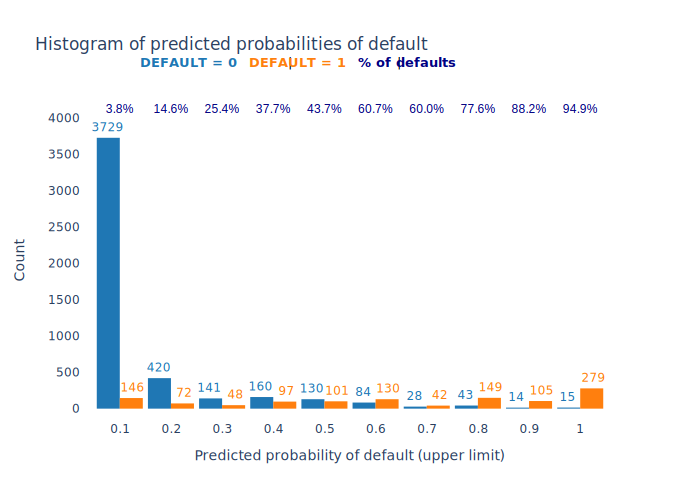

In [1023]:
colour_map = {
    0: "rgb(31, 119, 180)",  # Blue for DEFAULT = 0
    1: "rgb(255, 127, 14)",  # Orange for DEFAULT = 1
}

search_column = "predicted_probability"
default_column = "DEFAULT"

matched_column = next(
    (col for col in irb_df.columns if re.match(search_column, col, re.IGNORECASE)),
    None,
)

if not matched_column:
    raise KeyError(
        f"Column '{search_column}' not found in DataFrame! Available columns: {irb_df.columns}"
    )

if default_column not in irb_df.columns:
    raise KeyError(
        f"Column '{default_column}' not found in DataFrame! Available columns: {irb_df.columns}"
    )

bins = np.arange(0, 1.1, 0.1)

df_default_0 = irb_df[irb_df[default_column] == 0]
df_default_1 = irb_df[irb_df[default_column] == 1]

counts_0, bin_edges = np.histogram(df_default_0[matched_column], bins=bins)
counts_1, _ = np.histogram(df_default_1[matched_column], bins=bins)

total_counts = counts_0 + counts_1
default_percentages = np.where(total_counts > 0, (counts_1 / total_counts) * 100, 0)
default_percentage_labels = [
    f"{p:.1f}%" if total_counts[i] > 0 else ""
    for i, p in enumerate(default_percentages)
]

bin_width = 0.1
bin_centers = np.round((bin_edges[:-1] + bin_edges[1:]) / 2, 2)  # Explicit rounding

# Small shift to separate labels for DEFAULT 0 & 1
shift = bin_width / 4
x_positions_0 = bin_centers - shift
x_positions_1 = bin_centers + shift

max_bar_height = max(max(counts_0), max(counts_1))

fixed_annotation_height = max_bar_height + 300
y_positions_fixed = [fixed_annotation_height] * len(bin_centers)

fig = go.Figure()

# Blue bars for DEFAULT = 0
fig.add_trace(
    go.Histogram(
        x=df_default_0[matched_column],
        xbins=dict(start=0, end=1, size=0.10),
        marker=dict(color=colour_map[0]),
        name="DEFAULT = 0",
        opacity=1.0,
    )
)

# Orange bars for DEFAULT = 1
fig.add_trace(
    go.Histogram(
        x=df_default_1[matched_column],
        xbins=dict(start=0, end=1, size=0.10),
        marker=dict(color=colour_map[1]),
        name="DEFAULT = 1",
        opacity=1.0,
    )
)

# Count labels above bars for DEFAULT = 0
fig.add_trace(
    go.Scatter(
        x=x_positions_0,
        y=counts_0 + 50,  # Slight offset for visibility
        mode="text",
        text=counts_0,
        textposition="top center",
        textfont=dict(color=colour_map[0]),
        showlegend=False,
    )
)

# Count labels above bars for DEFAULT = 1
fig.add_trace(
    go.Scatter(
        x=x_positions_1,
        y=counts_1 + 50,
        mode="text",
        text=counts_1,
        textposition="top center",
        textfont=dict(color=colour_map[1]),
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=bin_centers,
        y=y_positions_fixed,
        mode="text",
        text=default_percentage_labels,
        textposition="top center",
        textfont=dict(color="navy", size=12, family="Arial"),
        showlegend=False,
    )
)

fig.add_annotation(
    x=-0.098,
    y=1.15,
    xref="paper",
    yref="paper",
    text=(
        "<span style='color:rgb(31, 119, 180);'><b>DEFAULT = 0</b></span> "
        "<span style='color:black;'>|</span> "
        "<span style='color:rgb(255, 127, 14);'><b>DEFAULT = 1</b></span> "
        "<span style='color:black;'>|</span> "
        "<span style='color:navy;'><b>% of defaults</b></span>"
    ),
    showarrow=False,
    font=dict(size=13),
    align="center",
)

fig.update_layout(
    title_text="Histogram of predicted probabilities of default",
    xaxis_title_text="Predicted probability of default (upper limit)",
    yaxis_title_text="Count",
    bargap=0.1,
    plot_bgcolor="white",
    barmode="group",
    showlegend=False,
    xaxis=dict(
        tickmode="array",
        tickvals=bin_centers,
        ticktext=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    ),
)

fig.show("svg")

The results above vary slightly from the monotonicity analysis in the previous section. This is because borrowers with missing property value and mortgage have now been dropped from the dataset. This has particularly affected the average default ratio of borrowers with a predicted probability of default of between 0.5 and 0.6, which is now higher than those with a predicted probability of between 0.6 and 0.7. This should be addressed in any future versions of the model.

To calculate capital requirements, I need to alter those borrowers in default so that the predicted probability becomes 1.0. 

In [1024]:
irb_df.loc[irb_df["DEFAULT"] == 1, "predicted_probability"] = 1.0


irb_df.head(20)

,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,LTV RATIO,missing_mortgage,missing_property_value,predicted_probability,dataset
idx,,,,,,,,
0,1,"25,860.00","39,025.00",0.66,0,0,1.00,Training
1,1,"70,053.00","68,400.00",1.02,0,0,1.00,Training
2,1,"13,500.00","16,700.00",0.81,0,0,1.00,Training
4,0,"97,800.00","112,000.00",0.87,0,0,0.56,Training
5,1,"30,548.00","40,320.00",0.76,0,0,1.00,Test
6,1,"48,649.00","57,037.00",0.85,0,0,1.00,Test
7,1,"28,502.00","43,034.00",0.66,0,0,1.00,Training
8,1,"32,700.00","46,740.00",0.70,0,0,1.00,Training
9,1,"42,563.51","62,250.00",0.68,1,0,1.00,Training


In [1025]:
def calculate_capital_requirement(pd, lgd=0.45, correlation=0.15):
    r = correlation
    numerator = (stats.norm.ppf(pd) / np.sqrt(1 - r)) + np.sqrt(
        r / (1 - r)
    ) * stats.norm.ppf(0.999)
    k = (lgd * stats.norm.cdf(numerator)) - (pd * lgd)
    return k


def calculate_rwa(ead, pd, lgd=0.45):
    k = calculate_capital_requirement(pd, lgd)
    rwa = 12.5 * ead * k
    return rwa


irb_df["correlation"] = 0.15


irb_df["LGD"] = 0.45

irb_df["k"] = irb_df.apply(
    lambda row: calculate_capital_requirement(
        row["predicted_probability"], row["LGD"], row["correlation"]
    ),
    axis=1,
)


irb_df["RWA_IRB"] = irb_df.apply(
    lambda row: calculate_rwa(
        row["OUTSTANDING MORTGAGE"], row["predicted_probability"], row["LGD"]
    ),
    axis=1,
)


# 'predicted_probability' = PD; 'OUTSTANDING MORTGAGE' = EAD


irb_df["EL"] = irb_df.apply(
    lambda row: row["predicted_probability"] * row["OUTSTANDING MORTGAGE"] * row["LGD"],
    axis=1,
)

In [1026]:
irb_df[irb_df["predicted_probability"] > 0.999]

,DEFAULT,OUTSTANDING MORTGAGE,PROPERTY VALUE,LTV RATIO,missing_mortgage,missing_property_value,predicted_probability,dataset,correlation,LGD,k,RWA_IRB,EL
idx,,,,,,,,,,,,,
0,1,"25,860.00","39,025.00",0.66,0,0,1.00,Training,0.15,0.45,0.00,0.00,"11,637.00"
1,1,"70,053.00","68,400.00",1.02,0,0,1.00,Training,0.15,0.45,0.00,0.00,"31,523.85"
2,1,"13,500.00","16,700.00",0.81,0,0,1.00,Training,0.15,0.45,0.00,0.00,"6,075.00"
5,1,"30,548.00","40,320.00",0.76,0,0,1.00,Test,0.15,0.45,0.00,0.00,"13,746.60"
6,1,"48,649.00","57,037.00",0.85,0,0,1.00,Test,0.15,0.45,0.00,0.00,"21,892.05"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5930,1,"58,118.85","85,000.00",0.68,1,0,1.00,Training,0.15,0.45,0.00,0.00,"26,153.48"
5931,1,"61,270.25","89,609.00",0.68,1,0,1.00,Test,0.15,0.45,0.00,0.00,"27,571.61"
5932,1,"38,206.00","90,000.00",0.42,0,0,1.00,Training,0.15,0.45,0.00,0.00,"17,192.70"


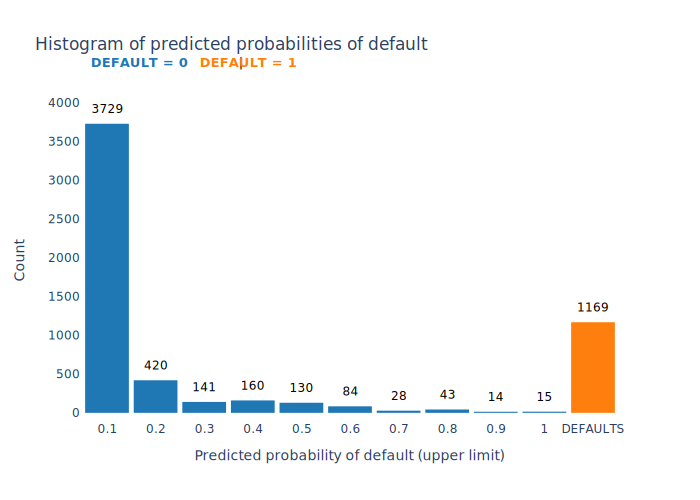

In [1027]:
colour_map = {
    0: "rgb(31, 119, 180)",
    1: "rgb(255, 127, 14)",
}

# Ensure column exists
search_column = "predicted_probability"
matched_column = next(
    (col for col in irb_df.columns if re.match(search_column, col, re.IGNORECASE)),
    None,
)

if not matched_column:
    raise KeyError(
        f"Column '{search_column}' not found in DataFrame! Available columns: {irb_df.columns}"
    )

bins = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999, 1.1])

bin_centers = np.round((bins[:-1] + bins[1:]) / 2, 2)

counts, _ = np.histogram(irb_df[matched_column], bins=bins)

final_bin_data = irb_df[irb_df[matched_column] >= 1.0][matched_column]
other_bin_data = irb_df[irb_df[matched_column] < 1.0][matched_column]

fig = go.Figure()

# Plot all bins except the last one (Blue)
fig.add_trace(
    go.Histogram(
        x=other_bin_data,
        xbins=dict(start=0, end=1.0, size=0.10),
        marker=dict(color=colour_map[0]),
        showlegend=False,
    )
)

# Plot the final bin separately (Orange)
fig.add_trace(
    go.Histogram(
        x=final_bin_data,
        xbins=dict(start=0.999, end=1.1, size=0.10),
        marker=dict(color=colour_map[1]),
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=bin_centers,
        y=counts + 100,
        mode="text",
        text=[str(c) if c > 0 else "" for c in counts],
        textposition="top center",
        textfont=dict(color="black", size=12),
        showlegend=False,
    )
)

fig.update_layout(
    title_text="Histogram of predicted probabilities of default",
    xaxis_title_text="Predicted probability of default (upper limit)",
    yaxis_title_text="Count",
    bargap=0.1,
    plot_bgcolor="white",
    xaxis=dict(
        tickmode="array",
        tickvals=bin_centers,
        ticktext=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "DEFAULTS"],
    ),
)

# Add subtitle using annotations
fig.add_annotation(
    x=-0.083,
    y=1.15,
    xref="paper",
    yref="paper",
    text="<span style='color:rgb(31, 119, 180);'><b>DEFAULT = 0</b></span> "
    "<span style='color:black;'>|</span> "
    "<span style='color:rgb(255, 127, 14);'><b>DEFAULT = 1</b></span>",
    showarrow=False,
    font=dict(size=13),
    align="center",
)

fig.show("svg")

### Summary of F-IRB results

In [1028]:
total_RWA_IRB = irb_df["RWA_IRB"].sum()
total_EAD_IRB = irb_df["OUTSTANDING MORTGAGE"].sum()
average_RW_IRB = total_RWA_IRB / total_EAD_IRB
CET1_req_IRB = total_RWA_IRB * 0.045  # 4.5% of RWA
tier1_req_IRB = total_RWA_IRB * 0.06  # 6% of RWA
total_capital_req_IRB = total_RWA_IRB * 0.08  # 8% of RWA
capital_perc_EAD_IRB = (total_capital_req_IRB / total_EAD_IRB) * 100

IRB_results_df = pd.DataFrame(
    {
        "Metric": [
            "Total RWA (IRB)",
            "Total EAD",
            "Average Risk Weight",
            "CET1 Requirement (4.5% of RWA)",
            "Tier 1 Requirement (6% of RWA)",
            "Total Capital Requirement (8% of RWA)",
            "Total Capital Requirement as % of EAD",
        ],
        "Value": [
            total_RWA_IRB,
            total_EAD_IRB,
            average_RW_IRB,
            CET1_req_IRB,
            tier1_req_IRB,
            total_capital_req_IRB,
            capital_perc_EAD_IRB,
        ],
    }
)

IRB_results_df.set_index("Metric", inplace=True)

IRB_results_df

,Value
Metric,
Total RWA (IRB),"474,727,437.71"
Total EAD,"420,538,686.01"
Average Risk Weight,1.13
CET1 Requirement (4.5% of RWA),"21,362,734.70"
Tier 1 Requirement (6% of RWA),"28,483,646.26"
Total Capital Requirement (8% of RWA),"37,978,195.02"
Total Capital Requirement as % of EAD,9.03


## Analysis of results

In [1029]:
combined_results_df = pd.DataFrame(
    {
        "Metric": [
            "Total RWA",
            "Total EAD",
            "Average Risk Weight",
            "CET1 Requirement (4.5% of RWA)",
            "Tier 1 Requirement (6% of RWA)",
            "Total Capital Requirement (8% of RWA)",
            "Total Capital Requirement as % of EAD",
        ],
        "F-IRB": [
            total_RWA_IRB,
            total_EAD_IRB,
            average_RW_IRB,
            CET1_req_IRB,
            tier1_req_IRB,
            total_capital_req_IRB,
            capital_perc_EAD_IRB,
        ],
        "SA": [
            total_RWA_SA,
            total_EAD_SA,
            average_RW_SA,
            CET1_req_SA,
            tier1_req_SA,
            total_capital_req_SA,
            capital_perc_EAD_SA,
        ],
    }
)

combined_results_df.set_index("Metric", inplace=True)
combined_results_df

,F-IRB,SA
Metric,,
Total RWA,"474,727,437.71","136,559,070.63"
Total EAD,"420,538,686.01","420,538,686.01"
Average Risk Weight,1.13,0.32
CET1 Requirement (4.5% of RWA),"21,362,734.70","6,145,158.18"
Tier 1 Requirement (6% of RWA),"28,483,646.26","8,193,544.24"
Total Capital Requirement (8% of RWA),"37,978,195.02","10,924,725.65"
Total Capital Requirement as % of EAD,9.03,2.60


Overall, risk-weighted assets and capital requirements are much lower under the standardised approach (SA) than the internal ratings-based approach (F-IRB). This is to be expected because the SA uses only the LTV ratio as a proxy for risk, and the average LTV ratio of around 0.7 seems neither high nor low for a bank offering residential mortgages.

On the other hand, the F-IRB approach is strongly impacted by the estimated probability of default (PD), which in this portfolio is around 20%. This seems to be a very high probability--one in five borrowers--and has a large impact on k (capital requirement), which in turn has a large impact on risk-weighted assets. Had the average PD been closer to around 1%, the total RWA for the F-IRB approach would have been quite similar to the SA. Similarly, had the LGD been calculated using a recovery rate, rather than using the recommended 0.45, this RWA may have been reduced further.  


### Caveats and questions

Under the standardised approach, I calculate EAD using the outstanding mortgage of all loans (both defaulted and non-defaulted), yet under the internal ratings-based approach, I calculate EAD using only the non-defaulted loans. I am unsure whether this is the correct method (I followed the suggested solution in the hands-on task, which did this, but it seems incorrect). If EAD should be measured the same way for both approaches, this will increase the discrepancy between the SA and F-IRB approaches.

EAD was calculated using outstanding mortgage values, which contained a number of anomalies (for example, some had LTV ratios of well above 1, which were considered to be incorrect, while others had null values). LTV ratios above 1.15 were then transformed (see 'Anomaly transformation' subsection in this notebook), reducing the value of some mortgages. Mortgages that were nulls were imputed using the mean LTV ratio of the portfolio, rather than the recommend LTV ratio of 0.45 (as specified in the task). Why did I do this? It seems unreasonable to assume that missing mortgages would represent values so significantly below the mean, and by filling nulls with such a low value, it would create an incentive to 'accidentally' remove/lose other mortgage values and replace them with a considerably lower imputed value.

For the F-IRB approach, is it reasonable to assume an LGD of 0.45 regardless of the LTV ratio? A low LTV ratio presumably would allow a greater percentage of losses to be recovered.


## References

BIS, 2017. High-level summary of Basel III reforms. Available at: https://www.bis.org/bcbs/publ/d424_hlsummary.pdf (Accessed 23 January 2025)

BIS, 2020a. Calculation of RWA for credit risk: IRB approach: risk weight functions. Available at: https://www.bis.org/basel_framework/chapter/CRE/31.htm (Accessed 25 January 2025)

BIS, 2020b. Risk-based capital requirements: Calculation of minimum risk-based capital requirements. Available at: https://www.bis.org/basel_framework/chapter/RBC/20.htm (Accessed 23 January 2025)

BIS, 2024. Calculation of RWA for credit risk: Standardised approach: individual exposures. Available at: https://www.bis.org/basel_framework/chapter/CRE/20.htm (Accessed 23 January 2025)